In [1]:
#copy the data from drive to colab. Copying a saved model from gdrive to colab.
!mkdir 'OA/'
!cp -r '/kaggle/input/osteoarthritis/MedicalExpert-I' '/OA/'

In [4]:
# libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import shutil


2024-05-29 18:22:53.513196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 18:22:53.513287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 18:22:53.648454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:

image_size = (224, 224)
batch_size = 32
train_ds = image_dataset_from_directory(
    "/kaggle/input/osteoarthritis/MedicalExpert-I",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    "/kaggle/input/osteoarthritis/MedicalExpert-I",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Found 1650 files belonging to 5 classes.
Using 330 files for validation.


In [6]:


# Define paths and parameters
base_path = '/kaggle/input/osteoarthritis/MedicalExpert-I'
output_path = '/kaggle/working/osteoarthritis_dataset'
image_size = (224, 224)
batch_size = 32

# Create output directories if they don't exist
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'val')

os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Helper function to save images to directory
def save_images_from_dataset(dataset, output_dir):
    class_names = dataset.class_names
    for class_name in class_names:
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            class_name = class_names[lbl.numpy()]
            class_dir = os.path.join(output_dir, class_name)
            img_path = os.path.join(class_dir, f'{tf.random.uniform((), 0, 1, dtype=tf.int32)}.png')
            tf.keras.preprocessing.image.save_img(img_path, img.numpy())

# Load datasets
train_ds = image_dataset_from_directory(
    base_path,
    labels="inferred",
    label_mode='int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    base_path,
    labels="inferred",
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Save images to respective directories
save_images_from_dataset(train_ds, train_output_path)
save_images_from_dataset(val_ds, val_output_path)

print(f"Training images saved to: {train_output_path}")
print(f"Validation images saved to: {val_output_path}")


Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Found 1650 files belonging to 5 classes.
Using 330 files for validation.
Training images saved to: /kaggle/working/osteoarthritis_dataset/train
Validation images saved to: /kaggle/working/osteoarthritis_dataset/val


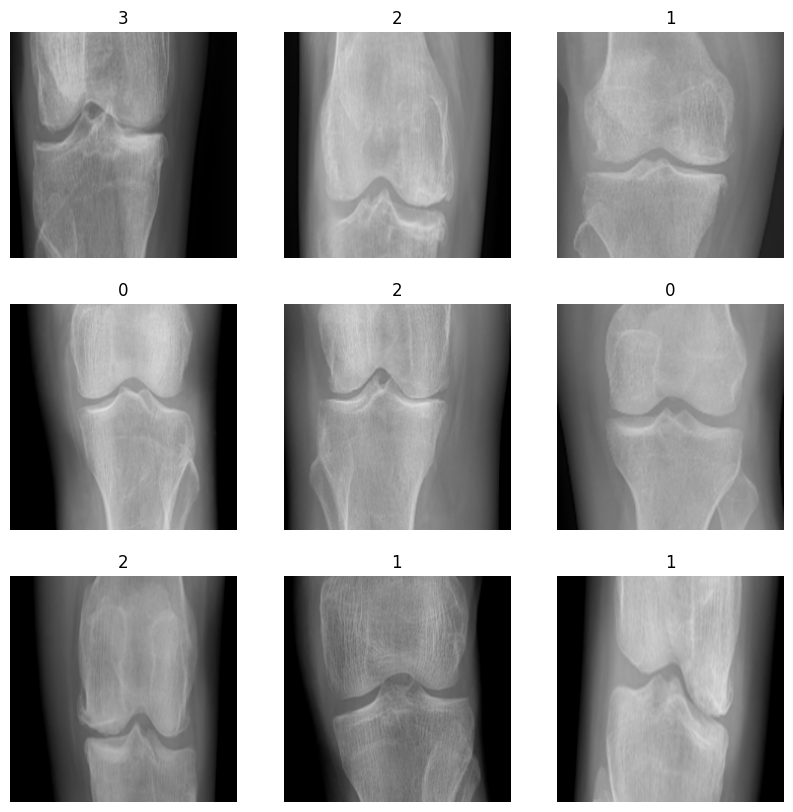

In [10]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
def apply_average_filter(image, filter_size):
    # Define the average filter kernel
    kernel = np.ones((filter_size, filter_size)) / (filter_size * filter_size)

    # Apply the filter to the image
    filtered_image = cv2.filter2D(image, -1, kernel)

    return filtered_image

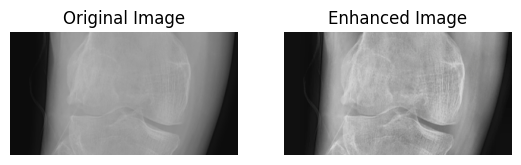

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply CLAHE
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel = lab_image[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_l_channel = clahe.apply(l_channel)
    lab_image[:, :, 0] = clahe_l_channel
    return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)

# Load the X-ray image (replace 'your_image_path' with the actual path)
image_path = '/kaggle/input/osteoarthritis/MedicalExpert-I/3Moderate/ModerateG3 (104).png'
xray_image = cv2.imread(image_path)

# Apply average filter to remove noise
filtered_image = apply_average_filter(xray_image, filter_size=16)

# Apply CLAHE to enhance contrast
enhanced_image = apply_clahe(xray_image)

# Plot the images using matplotlib.pyplot
plt.figure(figsize=(10, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(xray_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Enhanced Image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

input_shape = (224, 224, 3)
num_classes = 5  # Assuming 5 KL grades

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers[-10:]:  # Unfreezing last 10 layers, adjust as needed
    layer.trainable = True
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 58,219,520 (222.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [16]:

# Set up callbacks
callbacks = [
    ModelCheckpoint("best_enhanced_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=30,  # Adjust the number of epochs as needed
    validation_data=val_ds,
#     class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1717007322.689995     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.2840 - loss: 1.7377 - val_accuracy: 0.3485 - val_loss: 1.5284
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step - accuracy: 0.5968 - loss: 1.0337 - val_accuracy: 0.3727 - val_loss: 1.4207
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step - accuracy: 0.7466 - loss: 0.7378 - val_accuracy: 0.4273 - val_loss: 1.3125
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step - accuracy: 0.8360 - loss: 0.5512 - val_accuracy: 0.4939 - val_loss: 1.2158
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accuracy: 0.8932 - loss: 0.4012 - val_accuracy: 0.5061 - val_loss: 1.1738
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.9283 - loss: 0.2997 - val_accuracy: 0.5606 - val_loss: 1.1310
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - accuracy: 0.9489 - loss: 0.2393 - val_accuracy: 0.5788 - val_loss: 1.0438
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.9638 - loss: 0.1835 - val_accuracy: 0.5758 

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Confusion Matrix:
[[96  9  2  0  0]
 [17 72  2  1  1]
 [ 3 18 13  6  1]
 [ 2  5  4 31  7]
 [ 0  5  0  1 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       107
           1       0.66      0.77      0.71        93
           2       0.62      0.32      0.42        41
           3       0.79      0.63      0.70        49
           4       0.79      0.85      0.82        40

    accuracy                           0.75       330
   macro avg       0.74      0.69      0.70       330
weighted avg   

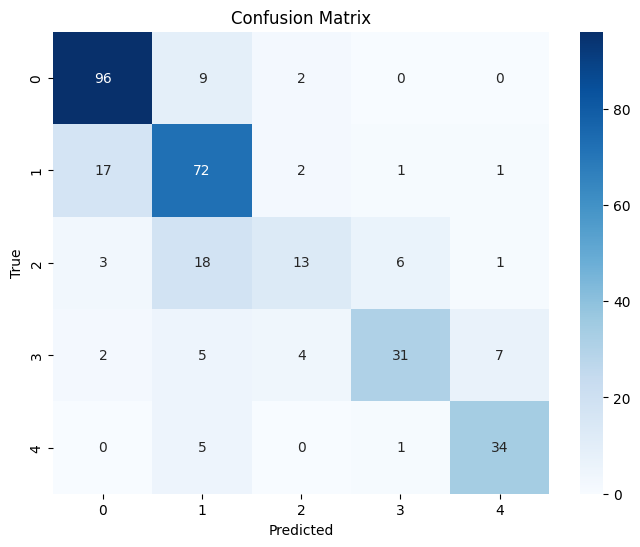


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       107
           1       0.66      0.77      0.71        93
           2       0.62      0.32      0.42        41
           3       0.79      0.63      0.70        49
           4       0.79      0.85      0.82        40

    accuracy                           0.75       330
   macro avg       0.74      0.69      0.70       330
weighted avg       0.74      0.75      0.73       330



In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ... (Previous code)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))


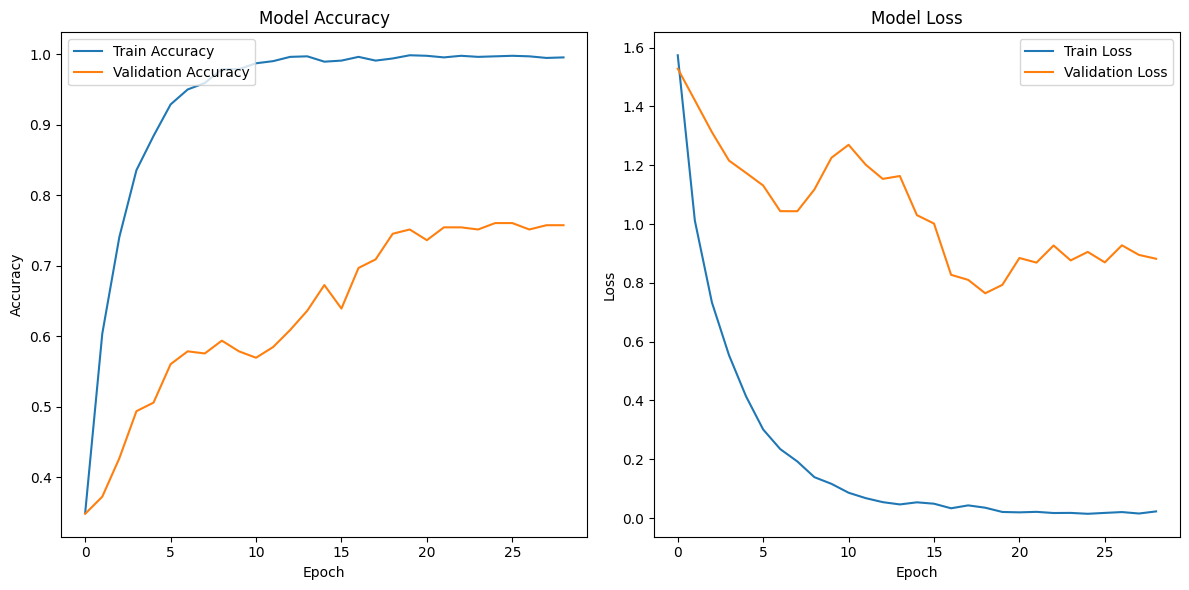

In [19]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


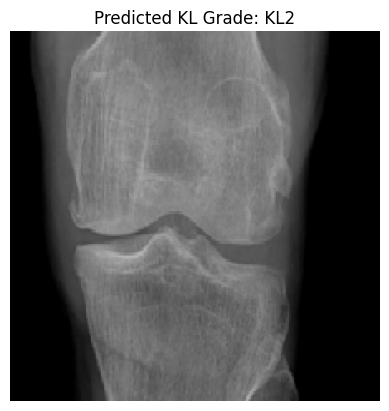

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

kl_grade_labels = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']
# Load and preprocess the image
img_path = '/kaggle/input/test-data/test_data/MildG2 (6).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


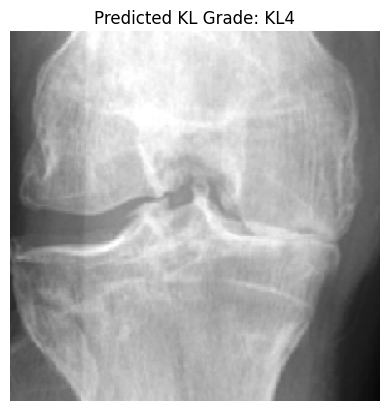

In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

kl_grade_labels = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']
# Load and preprocess the image
img_path = '/kaggle/input/test-data/test_data/SevereG4 (7).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


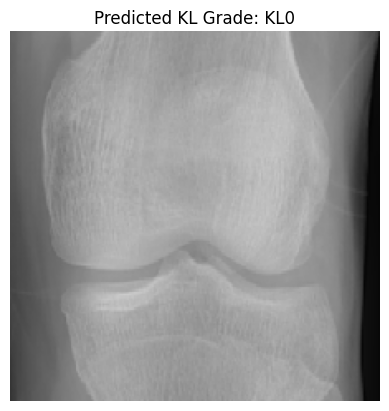

In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

kl_grade_labels = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']
# Load and preprocess the image
img_path = '/kaggle/input/test-data/test_data/NormalG0 (5).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


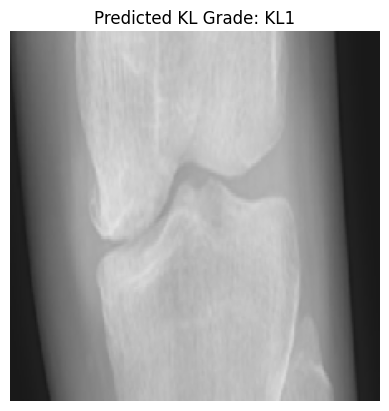

In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

kl_grade_labels = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']
# Load and preprocess the image
img_path = '/kaggle/input/test-data/test_data/DoubtfulG1 (94).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')
plt.show()
